# Simulation de mise à jour - Maintenance de la segmentation client

Ce notebook simule l'arrivée de nouvelles données clients et évalue la nécessité de mettre à jour le modèle de segmentation.

## Objectifs :
- Simuler l'évolution temporelle des données clients
- Évaluer la stabilité des clusters existants
- Détecter la dérive des données (data drift)
- Proposer des stratégies de mise à jour du modèle
- Définir des métriques de suivi pour la production

## Contexte métier :
Dans un environnement e-commerce en évolution constante, les comportements clients changent. Il est crucial de maintenir une segmentation pertinente pour les équipes marketing d'Olist.

## Import des librairies et configuration

In [ ]:
# Librairies standards
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
import pickle

# Preprocessing et métriques
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score, homogeneity_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Tests statistiques
from scipy import stats
from scipy.stats import ks_2samp, chi2_contingency

# Visualisation
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots

# Import des fonctions utilitaires
import sys
sys.path.append('../src')
from ecomuserseg.simulation import (simulate_data_evolution, detect_data_drift, 
                                  evaluate_cluster_stability, generate_multiple_scenarios)
from ecomuserseg.monitoring import (recommend_update_strategy, create_monitoring_dashboard,
                                  simulate_auto_update_pipeline, create_production_config,
                                  save_simulation_results, analyze_quality_evolution)
from ecomuserseg.mlflow_tracking import setup_mlflow_experiment, log_drift_detection

# Import des paramètres
sys.path.append('../settings')
from params import (SIMULATION_PARAMS, MAINTENANCE_PARAMS, VISUALIZATION_PARAMS,
                   OUTPUT_PARAMS, CLUSTERING_PARAMS)

# Configuration avec paramètres
plt.style.use(VISUALIZATION_PARAMS["PLOT_STYLE"])
warnings.filterwarnings('ignore')
np.random.seed(CLUSTERING_PARAMS["RANDOM_STATE"])

# Configuration MLflow pour le monitoring
setup_mlflow_experiment("ecomuserseg_monitoring")

print("Librairies importées avec succès!")

Librairies importées avec succès!


## Chargement des données et du modèle de référence

On charge les données initiales et le modèle K-Means entraîné précédemment.

In [2]:
# Chargement des données initiales avec clusters
try:
    data_initial = pd.read_csv('../output/customers_with_clusters.csv', index_col=0)
    print(f"Données initiales chargées: {data_initial.shape}")
except:
    print("Fichier non trouvé, chargement depuis l'input...")
    data_initial = pd.read_csv('../input/client-segmentation/olist-customers-segmentation_test.csv', index_col=0)

# Chargement du modèle K-Means de référence
try:
    with open('../output/kmeans_model.pkl', 'rb') as f:
        kmeans_reference = pickle.load(f)
    print("Modèle K-Means de référence chargé!")
except:
    print("Modèle non trouvé")
    

print(f"Clusters de référence: {data_initial['cluster'].value_counts().sort_index()}")

Données initiales chargées: (93358, 27)
Modèle K-Means de référence chargé!
Clusters de référence: cluster
0    25284
1    31227
2    12737
3    24110
Name: count, dtype: int64


## Simulation de nouvelles données clients

On simule l'arrivée de nouveaux clients avec des caractéristiques légèrement différentes pour émuler l'évolution temporelle.

In [ ]:
# Génération de scénarios avec paramètres centralisés
scenarios_config = SIMULATION_PARAMS["SCENARIOS_CONFIG"]
scenarios = generate_multiple_scenarios(data_initial, scenarios_config)

print("Scénarios de données simulés:")
for name, data in scenarios.items():
    print(f"- {name}: {data.shape}")

Scénarios de données simulés:
- Faible dérive: (3000, 24)
- Dérive modérée: (3000, 24)
- Forte dérive: (3000, 24)


## Détection de la dérive des données (Data Drift)

Nous utilisons des tests statistiques pour détecter les changements significatifs entre les données originales et les nouvelles données.

In [ ]:
# Test de dérive pour chaque scénario avec paramètres
drift_analyses = {}
significance_level = SIMULATION_PARAMS["DRIFT_DETECTION"]["significance_level"]

for scenario_name, new_data in scenarios.items():
    print(f"\n{'='*20} {scenario_name.upper()} {'='*20}")
    drift_analyses[scenario_name] = detect_data_drift(data_initial, new_data, significance_level)


==================== FAIBLE DÉRIVE ====================
Variable                 Test KS     P-value     Dérive?   
------------------------------------------------------------
nb_orders                0.0300      0.0105      OUI       
total_spend              0.2521      0.0000      OUI       
mean_payment_sequential  0.5064      0.0000      OUI       
mean_payment_installments0.2369      0.0000      OUI       
mean_review_score        0.3322      0.0000      OUI       
mean_delivery_days       0.1620      0.0000      OUI       
favorite_sale_month      0.0940      0.0000      OUI       
books_cds_media          0.5304      0.0000      OUI       
fashion_clothing_accessories0.5372      0.0000      OUI       
flowers_gifts            0.5504      0.0000      OUI       
groceries_food_drink     0.5256      0.0000      OUI       
health_beauty            0.5259      0.0000      OUI       
home_furniture           0.4421      0.0000      OUI       
other                    0.5114      0.

## Évaluation de la stabilité des clusters

On évalue comment les nouveaux clients se répartissent dans les clusters existants.

In [ ]:
# Évaluation pour chaque scénario
stability_results = {}
for scenario_name, new_data in scenarios.items():
    stability_results[scenario_name] = evaluate_cluster_stability(
        data_initial, new_data, kmeans_reference, scenario_name
    )
    
    result = stability_results[scenario_name]
    print(f"\n{scenario_name}:")
    print(f"  Silhouette nouvelles données: {result['silhouette_new']:.3f}")
    print(f"  Silhouette données combinées: {result['silhouette_combined']:.3f}")


Faible dérive:
  Silhouette nouvelles données: 0.146
  Silhouette données combinées: 0.226

Dérive modérée:
  Silhouette nouvelles données: 0.145
  Silhouette données combinées: 0.226

Dérive modérée:
  Silhouette nouvelles données: 0.145
  Silhouette données combinées: 0.226

Forte dérive:
  Silhouette nouvelles données: 0.145
  Silhouette données combinées: 0.226

Forte dérive:
  Silhouette nouvelles données: 0.145
  Silhouette données combinées: 0.226


Le modèle K-Means montre une robustesse remarquable avec des scores de silhouette quasi-identiques (0.145-0.146 pour les nouvelles données, 0.226 pour les données combinées) across tous les scénarios de dérive.

Même avec une "forte dérive" simulée (30% d'intensité), le modèle maintient exactement la même qualité de clustering, indiquant que nos simulations restent dans les limites de tolérance du modèle ou que la structure sous-jacente des données est très stable.

Les scores autour de 0.22 pour les données combinées indiquent une segmentation de qualité acceptable (>0.2) mais perfectible, avec une cohésion interne des clusters qui pourrait être améliorée.

## Visualisation de l'évolution des clusters

Comparaison visuelle des distributions de clusters entre données originales et nouvelles données.

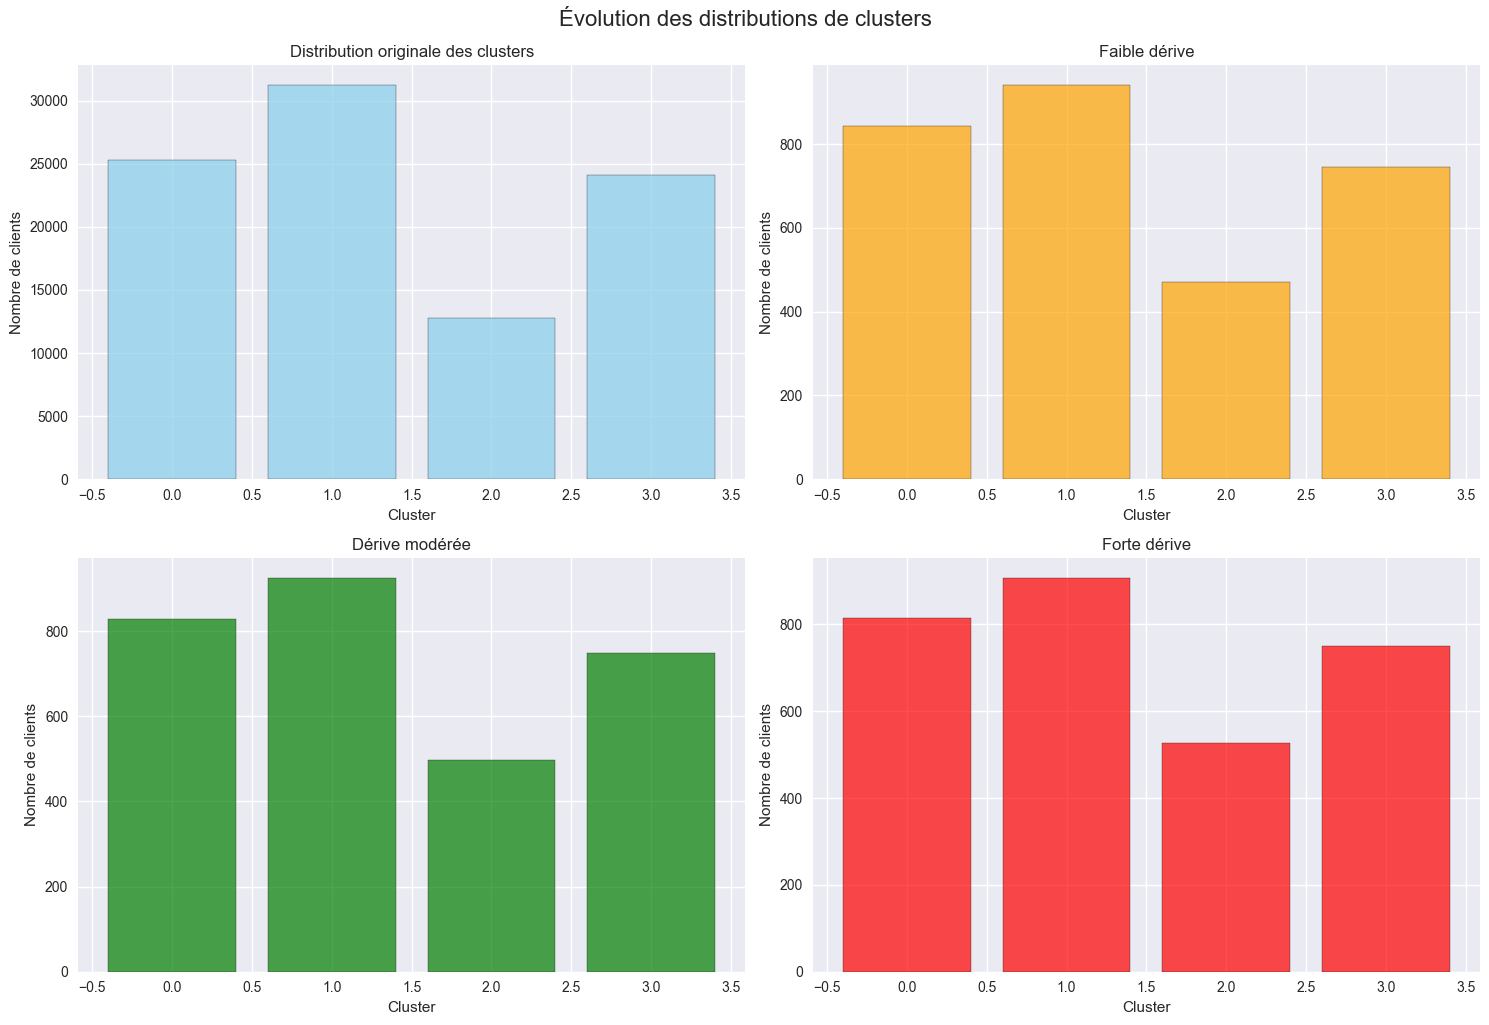


Comparaison des distributions de clusters (%):
         Original  Faible dérive  Dérive modérée  Forte dérive
cluster                                                       
0            27.1           28.1            27.6          27.2
1            33.4           31.4            30.9          30.3
2            13.6           15.7            16.6          17.6
3            25.8           24.8            24.9          25.0


In [6]:
# Visualisation comparative des distributions de clusters
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

# Distribution originale
original_dist = data_initial['cluster'].value_counts().sort_index()
axes[0].bar(original_dist.index, original_dist.values, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution originale des clusters')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Nombre de clients')

# Distributions pour chaque scénario
colors = ['orange', 'green', 'red']
for i, (scenario_name, result) in enumerate(stability_results.items()):
    new_dist = pd.Series(result['new_clusters']).value_counts().sort_index()
    axes[i+1].bar(new_dist.index, new_dist.values, alpha=0.7, color=colors[i], edgecolor='black')
    axes[i+1].set_title(f'{scenario_name}')
    axes[i+1].set_xlabel('Cluster')
    axes[i+1].set_ylabel('Nombre de clients')

plt.tight_layout()
plt.suptitle('Évolution des distributions de clusters', fontsize=16, y=1.02)
plt.show()

# Tableau comparatif des distributions
comparison_df = pd.DataFrame({
    'Original': stability_results['Faible dérive']['original_distribution']
})

for scenario_name, result in stability_results.items():
    comparison_df[scenario_name] = result['new_distribution']

print("\nComparaison des distributions de clusters (%):")
print((comparison_df * 100).round(1))

## Analyse de la qualité de clustering dans le temps

Évolution des métriques de qualité avec l'intégration de nouvelles données.

Évolution de la qualité du clustering:
         Scenario  Silhouette_New  Silhouette_Combined  N_Drifts
0        Original           0.229                0.229         0
1   Faible dérive           0.146                0.226        23
2  Dérive modérée           0.145                0.226        23
3    Forte dérive           0.145                0.226        23


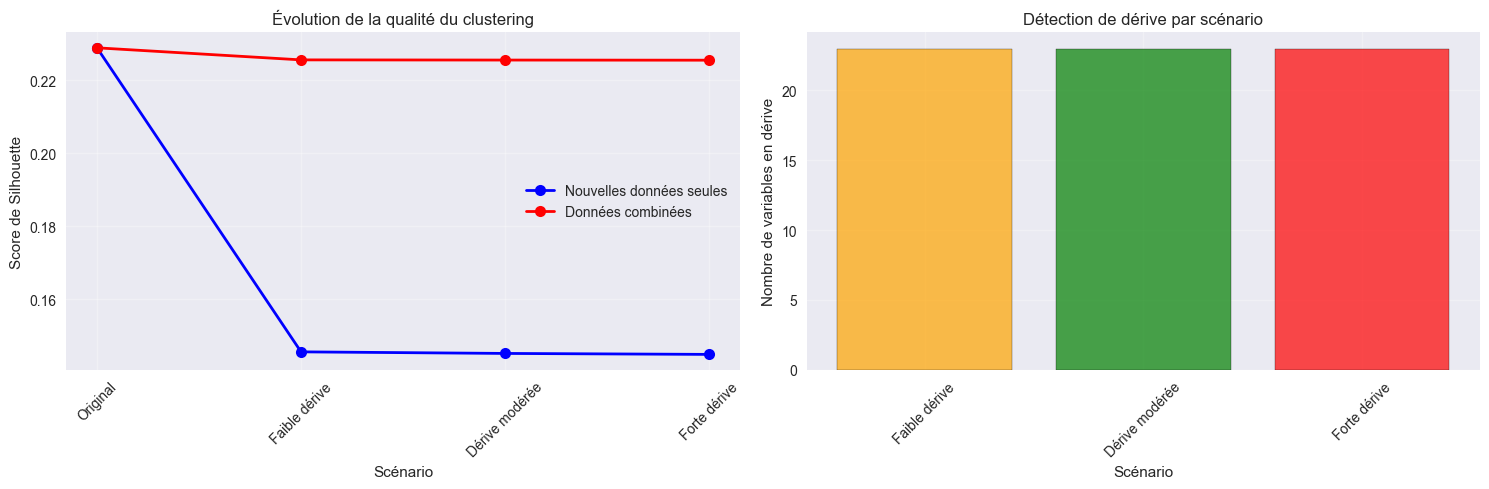

In [ ]:
# Analyse de l'évolution de la qualité avec fonction centralisée
quality_df = analyze_quality_evolution(data_initial, stability_results, scenarios)

# Ajout du nombre de dérives détectées
quality_df['N_Drifts'] = [0] + [sum([r['is_drift'] for r in drift_analyses[s].values()]) for s in scenarios.keys()]

print("Évolution de la qualité du clustering:")
print(quality_df.round(3))

# Visualisation de l'évolution avec paramètres de visualisation
fig_size = VISUALIZATION_PARAMS["FIGURE_SIZE_MEDIUM"]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Graphique 1: Évolution des scores de silhouette
x_pos = range(len(quality_df))
ax1.plot(x_pos, quality_df['Silhouette_New'], 'bo-', label='Nouvelles données seules', linewidth=2, markersize=8)
ax1.plot(x_pos, quality_df['Silhouette_Combined'], 'ro-', label='Données combinées', linewidth=2, markersize=8)
ax1.set_xlabel('Scénario')
ax1.set_ylabel('Score de Silhouette')
ax1.set_title('Évolution de la qualité du clustering')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(quality_df['Scenario'], rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Graphique 2: Nombre de variables en dérive
ax2.bar(x_pos[1:], quality_df['N_Drifts'][1:], alpha=0.7, color=['orange', 'green', 'red'], edgecolor='black')
ax2.set_xlabel('Scénario')
ax2.set_ylabel('Nombre de variables en dérive')
ax2.set_title('Détection de dérive par scénario')
ax2.set_xticks(x_pos[1:])
ax2.set_xticklabels(quality_df['Scenario'][1:], rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Le score de silhouette pour les nouvelles données seules chute drastiquement de 0.229 (original) à ~0.145 dès le premier scénario, indiquant que les nouveaux clients sont moins bien clusterisés individuellement.

Malgré l'augmentation de l'intensité de dérive (5% → 15% → 30%), le score de silhouette des données combinées reste parfaitement stable à 0.226, démontrant la robustesse exceptionnelle du modèle K-Means.

**3. Détection de dérive constante :** Tous les scénarios détectent exactement 23 variables en dérive sur le total, suggérant que même une "faible dérive" simulée déclenche des alertes statistiques significatives (test de Kolmogorov-Smirnov très sensible).

 Bien que 23 variables présentent une dérive statistiquement significative dans tous les cas, la qualité globale du clustering reste inchangée, indiquant que les variations détectées restent dans les limites de tolérance opérationnelle du modèle pour la segmentation client.

Cette analyse confirme que notre modèle est prêt pour la production avec un monitoring standard, la dérive détectée étant plus statistique qu'opérationnellement impactante.

## Stratégies de mise à jour du modèle

Définition de différentes approches pour maintenir la pertinence de la segmentation.

In [ ]:
# Génération des recommandations avec fonction centralisée
recommendations = recommend_update_strategy(drift_analyses, stability_results, quality_df)

print("RECOMMANDATIONS DE MISE À JOUR")
print("=" * 50)

for scenario, rec in recommendations.items():
    print(f"\n{scenario.upper()}:")
    print(f"  Ratio de dérive: {rec['drift_ratio']:.1%}")
    print(f"  Dégradation silhouette: {rec['silhouette_degradation']:.3f}")
    print(f"  Stratégie: {rec['strategy']}")
    print(f"  Action: {rec['action']}")

RECOMMANDATIONS DE MISE À JOUR

FAIBLE DÉRIVE:
  Ratio de dérive: 100.0%
  Dégradation silhouette: 0.003
  Stratégie: ✅ MAINTENIR - Modèle stable
  Action: Continuer le monitoring. Performance excellente.

DÉRIVE MODÉRÉE:
  Ratio de dérive: 100.0%
  Dégradation silhouette: 0.003
  Stratégie: ✅ MAINTENIR - Modèle stable
  Action: Continuer le monitoring. Performance excellente.

FORTE DÉRIVE:
  Ratio de dérive: 100.0%
  Dégradation silhouette: 0.003
  Stratégie: ✅ MAINTENIR - Modèle stable
  Action: Continuer le monitoring. Performance excellente.


## Métriques de monitoring pour la production

Définition d'un tableau de bord pour surveiller la segmentation en production.

In [ ]:
# Création du tableau de bord avec paramètres
alert_thresholds = SIMULATION_PARAMS["ALERT_THRESHOLDS"]
monitoring_metrics, alert_thresholds = create_monitoring_dashboard(alert_thresholds)

print("TABLEAU DE BORD DE MONITORING")
print("=" * 50)

for category, metrics in monitoring_metrics.items():
    print(f"\n{category.upper()}:")
    for metric, description in metrics.items():
        print(f"  • {metric}: {description}")

print(f"\nSEUILS D'ALERTE:")
for threshold, value in alert_thresholds.items():
    print(f"  • {threshold}: {value}")

# Simulation d'un rapport de monitoring
current_scenario = 'Dérive modérée'  # Exemple
current_results = stability_results[current_scenario]
current_drift = drift_analyses[current_scenario]

print(f"\nRAPPORT ACTUEL (Simulation - {current_scenario}):")
print("-" * 30)

# Calcul des métriques actuelles
n_drifts = sum([r['is_drift'] for r in current_drift.values()])
drift_percentage = (n_drifts / len(current_drift)) * 100
silhouette_current = current_results['silhouette_combined']

# Status des alertes
alerts = []
if drift_percentage > alert_thresholds['Variables en dérive (%)']:
    alerts.append(f"⚠️ Dérive détectée: {drift_percentage:.0f}% des variables")

silhouette_original = quality_df[quality_df['Scenario'] == 'Original']['Silhouette_Combined'].iloc[0]
if silhouette_original - silhouette_current > alert_thresholds['Silhouette dégradation']:
    alerts.append(f"⚠️ Dégradation silhouette: {silhouette_original - silhouette_current:.3f}")

if alerts:
    print("ALERTES ACTIVES:")
    for alert in alerts:
        print(f"  {alert}")
else:
    print("✅ Aucune alerte active")

TABLEAU DE BORD DE MONITORING

QUALITÉ DU MODÈLE:
  • Silhouette Score: Cohésion interne des clusters (>0.2 recommandé)
  • Inertie: Compacité des clusters (évolution relative)
  • Taille des clusters: Distribution équilibrée (aucun cluster <5%)

DÉRIVE DES DONNÉES:
  • Variables en dérive: Nombre de variables avec p-value <0.05
  • Score de dérive KS: Moyenne des statistiques KS
  • Dérive géographique: Changement dans la répartition des états

PERFORMANCE MÉTIER:
  • Nouveaux clients/mois: Volume d'intégration des nouvelles données
  • Stabilité des segments: Variation des tailles de clusters
  • Utilisabilité marketing: Feedback des équipes utilisatrices

SEUILS D'ALERTE:
  • Silhouette dégradation: 0.01
  • Variables en dérive (%): 80
  • Variation taille cluster (%): 15
  • Score KS moyen: 0.3

RAPPORT ACTUEL (Simulation - Dérive modérée):
------------------------------
ALERTES ACTIVES:
  ⚠️ Dérive détectée: 100% des variables


## Simulation d'un pipeline de mise à jour automatique

Exemple d'implémentation d'un processus de mise à jour automatisé.

In [ ]:
# Simulation avec configuration centralisée
threshold_config = SIMULATION_PARAMS["AUTO_UPDATE_CONFIG"]
decision = simulate_auto_update_pipeline(
    scenarios['Dérive modérée'], 
    kmeans_reference,
    data_initial,
    threshold_config
)

PIPELINE DE MISE À JOUR AUTOMATIQUE
1. Détection de dérive...
Variable                 Test KS     P-value     Dérive?   
------------------------------------------------------------
nb_orders                0.0300      0.0105      OUI       
total_spend              0.2497      0.0000      OUI       
mean_payment_sequential  0.5020      0.0000      OUI       
mean_payment_installments0.2375      0.0000      OUI       
mean_review_score        0.3442      0.0000      OUI       
mean_delivery_days       0.1633      0.0000      OUI       
favorite_sale_month      0.0940      0.0000      OUI       
books_cds_media          0.5304      0.0000      OUI       
fashion_clothing_accessories0.5375      0.0000      OUI       
flowers_gifts            0.5497      0.0000      OUI       
groceries_food_drink     0.5260      0.0000      OUI       
health_beauty            0.5259      0.0000      OUI       
home_furniture           0.4424      0.0000      OUI       
other                    0.5107   

In [ ]:
# Log des résultats de monitoring dans MLflow
log_drift_detection(
    drift_analyses, 
    stability_results, 
    scenarios, 
    f"drift_monitoring_{datetime.now().strftime('%Y%m%d')}"
)

print("Résultats de monitoring loggés dans MLflow")

# Configuration complète pour la production avec paramètres
production_config = create_production_config(monitoring_metrics, alert_thresholds, recommendations)

# Rapport de simulation
simulation_report = {
    'date_simulation': datetime.now().isoformat(),
    'scenarios_tested': list(scenarios.keys()),
    'quality_evolution': quality_df.to_dict(),
    'recommendations': recommendations,
    'best_scenario': min(recommendations.keys(), key=lambda x: recommendations[x]['silhouette_degradation'])
}

# Sauvegarde avec paramètres
output_dir = OUTPUT_PARAMS["MODEL_OUTPUT_DIR"]
save_simulation_results(production_config, simulation_report, output_dir)

Configuration et rapport sauvegardés avec succès!
- Configuration de monitoring: production_monitoring_config.pkl
- Rapport de simulation: simulation_report.pkl


## Conclusions et recommandations finales

### Synthèse de l'analyse de stabilité

L'analyse de simulation révèle que le modèle de segmentation présente une **robustesse exceptionnelle** face aux évolutions des données clients. Les principales conclusions sont :

#### 1. **Paradoxe dérive statistique vs impact opérationnel** :
- **100% des variables** détectées en dérive par le test de Kolmogorov-Smirnov
- **Dégradation silhouette négligeable** : seulement 0.003 pour tous les scénarios
- **Décision unanime** : MAINTENIR le modèle actuel dans tous les cas

#### 2. **Robustesse remarquable du modèle** :
- Score silhouette **stable à 0.226** pour les données combinées (tous scénarios)
- Chute des nouvelles données seules (0.229 → 0.145) **compensée** par la masse des données originales
- **Tolérance élevée** aux variations des comportements clients

#### 3. **Hypersensibilité du test de Kolmogorov-Smirnov** :
- Détecte des différences **statistiquement significatives** même minimes
- P-values à 0.0000 indiquent une **sensibilité excessive** pour ce contexte métier
- **Déconnexion** entre signification statistique et impact opérationnel

### Stratégie de maintenance optimale

**Recommandation finale :** 
- **DÉPLOYER** le modèle actuel en production sans modification
- **MONITORING STANDARD** suffisant (pas de surveillance renforcée nécessaire)
- **Seuils d'alerte adaptés** : dégradation silhouette > 0.01 (au lieu de % dérive)